# Medicare Part D Prescriber Data Analysis

In this notebook, I used the SQL file generated by the `Data Processing.ipynb` to answer questions I had about the Medicare Part D providers and their prescribing patterns. Specifically, these questions include:

* What is the cost distribution by state? Does this make sense intuitively?
* Are there any patterns in outlying prescribers?  Does it appear that any of these prescribers are blatantly committing fraud?
* Is there a significant cost difference in generic drugs versus brand name drugs? If so, why does this seem to be the case?
* Does the average cost of drugs increase by 8-12% per year (as assumed in the private insurance market)?  What seems to be driving this increase?

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import sqlalchemy as sqla
import sqlite3
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import numpy as np
import requests
import requests_cache
import matplotlib as mpl
import matplotlib.ticker as mtick
import mpld3
from mpld3 import plugins
from wordcloud import WordCloud


mpl.rcParams['figure.figsize'] = [10, 6]
requests_cache.install_cache("stateFIPS")
sqlite_file = 'MedicareData.sqlite'
rx_conn = sqla.create_engine('sqlite:///' + sqlite_file)
years = [13,14,15]
plt.style.use('ggplot')

### What is the distribution of prescription cost by state?  Is it uniform, or do some states tend to have higher prescribing costs than others?

As we will see, the Medicare part D program is quite an expensive endeavor, and as such, some may be interested in reducing the cost of the program.  One way we could begin to explore accomplishing this is to explore the cost of the Medicare part D program by state/region to determine if prescribing patterns and/or tax and fee schedules are drastically different in some states are than in others.  If so, then the Center of Medicare and Medicaid Services could make targeted efforts to reduce costs/expenditures in the necessary states.

Before taclking this question, let's do some baseline exploratory analysis of the data.

In [3]:
# saves total cost per state
for year in years:
    query = """select state, sum(cost) as total_cost{}, sum(num_claims) as num_claims{}
    from rx20{} 
    group by state 
    order by total_cost{} desc""".format(year, year, year, year)
    try:
        cost_by_state = cost_by_state.merge(pd.read_sql_query(query, rx_conn), on= 'state')
    except NameError:
        cost_by_state = pd.read_sql_query(query, rx_conn)

# cache query
cost_by_state.to_csv("summaryData/CostByState.csv", index = False)

In [4]:
# allows me to convert back and forth between State name FIP # and Abbreviation
def state_fip2abbvname(fip_number, abbrev):
    """Returns the 2 digit state abbreviation (if abbrev == True) or the state name (if abbrev == False)
    for the state with the FIP # fip_number
    """
    base_url = "https://www.broadbandmap.gov/broadbandmap/census/state/fips/{num:02d}".format(num = fip_number)
    results = requests.get(base_url, params={"format": "json"})
    
    try:
        return results.json()['Results']['state'][0]['stateCode'] if abbrev == True \
                else results.json()['Results']['state'][0]['name'] 
    except (KeyError, IndexError):
        return

# Dictionaries to go through diff ways of naming states
abbv2FIPS = {state_fip2abbvname(i, True): "{num:02d}".format(num = i) for i in range(1,101)} 
name2abbv = {state_fip2abbvname(i, False): state_fip2abbvname(i, True) for i in range(1,101)} 

In [5]:
# read enrollment data from other Medicare file
def read_Enrollment_Data(sheet_name, rows_2_skip, cols, new_cols, data_df):
    """Read in Medicare Data Enrollment Data from Excel File
    
    Arguments:
        -sheet_name (string): name of the sheet to read in
        -rows_2_skip (int): number of rows to skip on sheet to read in
        -cols (list): list of columns to read in (as given in the excel file)
        -new_cols (list): name of columns in resulting data frame
        -data_df (DataFrame): data frame to merge state enrollment data to
    """
    df = pd.read_excel("MedicareData/Enrollment_Dashboard_Data_File_12_28_2017.xlsx",
                           sheet_name=sheet_name, 
                           skiprows = rows_2_skip)[cols]
    df[cols[2:]] = df[cols[2:]].apply(pd.to_numeric, errors = 'coerce')
    df.columns = ["State","County"] + new_cols
    df = df[df.County.str.upper() == "TOTAL"]
    df = df.groupby("State").sum()
    df['state'] = [dictionary_get_with_fail(name2abbv, s) for s in df.index]
    df = data_df.merge(df, how = 'inner', on='state')
    return df

In [6]:
# for ease of accessing dictionary without error 
def dictionary_get_with_fail(dictionary, key):
    """trys to return the value corresponding to the key, key, from the dict, dictionary
       if key does not exist, then this function returns none
    """
    try:
        return dictionary[key]
    except KeyError:
        return

In [7]:
def plot_US(map_df, col, ccmap, legend_b, title):
    """Plot a choropleth map of the continental US using the column of data col in map_df
    
    Arguments:
        -map_df (GeoPandas df): DataFrame to make a map from
        -col (string): name of column to print on choropleth map
        -ccmap (string): color map to use on the map
        -legend_b (bool): True/False value on whether or not to include a legend
        -title (string): title of the resulting map
    """
    ax = map_df.dropna(how = "any").plot(figsize = (15,8),column = col, cmap = ccmap, legend = legend_b)
    ax.set_xlim([-130, -65])
    ax.set_ylim([23, 50])
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

In [8]:
def pandas_plot(df, x, y, ccol, kkind, legend_b, xlab, ylab, title):
    """make a pandas plot from the dataframe df with the given parameters
    
    Arguments:
        -df (Pandas df): DataFrame with data to plot
        -x (string): name of columns to print on x axis
        -y (string): name of columns to print on y axis
        -ccol (string): color argument to pass to df.plot
        -legend_b (bool): True/False value on whether or not to include a legend
        -xlab (string): label to include on x axis
        -ylab (string): label to include on y axis
        -title (string): title of the resulting map
    """
    if ccol == "":
        ax = df.plot(x, y, kind=kkind, legend=legend_b)
    else:
        ax = df.plot(x, y, color=ccol, kind=kkind, legend=legend_b)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    plt.show()

In [9]:
# add necessary fields to the data
cost_by_state = pd.read_csv("summaryData/CostByState.csv")
cost_by_state['FIPS'] = [dictionary_get_with_fail(abbv2FIPS, s) for s in cost_by_state['state']]
cost_by_state = read_Enrollment_Data("Yearly Enrollment Counts", 6, 
                                     ["State", "County", "Total.3", "Total.5", "Total.7"], 
                                     ["partd_cnt13", "partd_cnt14", "partd_cnt15"], cost_by_state)

for year in years:
    cost_by_state['avg_cost{}'.format(year)] = (cost_by_state['total_cost{}'.format(year)] / 
                                                cost_by_state['partd_cnt{}'.format(year)])
    cost_by_state['avg_claims{}'.format(year)] = (cost_by_state['num_claims{}'.format(year)] / 
                                                  cost_by_state['partd_cnt{}'.format(year)])

# show some statistics
cost_by_state[sorted([coln for coln in cost_by_state.columns if coln[-2:].isdigit()])[-9:]].sum()

num_claims13    1.155207e+09
num_claims14    1.194837e+09
num_claims15    1.223058e+09
partd_cnt13     3.565744e+07
partd_cnt14     3.769468e+07
partd_cnt15     3.948338e+07
total_cost13    7.867665e+10
total_cost14    9.151852e+10
total_cost15    1.024976e+11
dtype: float64

Above we see the total prescription cost from Medicare Part D plan for each year. It appears that the total year cost of the Medicare part D section was roughly:

* \$78.7 billion in 2013
* \$91.5 billion in 2014
* \$102.5 billion in 2015

Also, we see the Medicare part D population has increased from 35.6 million to 39.5 million people and the total number of prescriptions made has increased from 1.155 billion per year to 1.223 billion per year over from 2013 to 2015.

As a check for the validity of the data, let's look at the total cost of the Medicare Part D program in 2015 for each state via a choropleth map. Although this won't derive any insight on where costs **per person** were actually higher and lower in the U.S., it could show us whether or not there is something critically wrong with the data (i.e. if most prescription costs were being written from Wyoming or something like that).

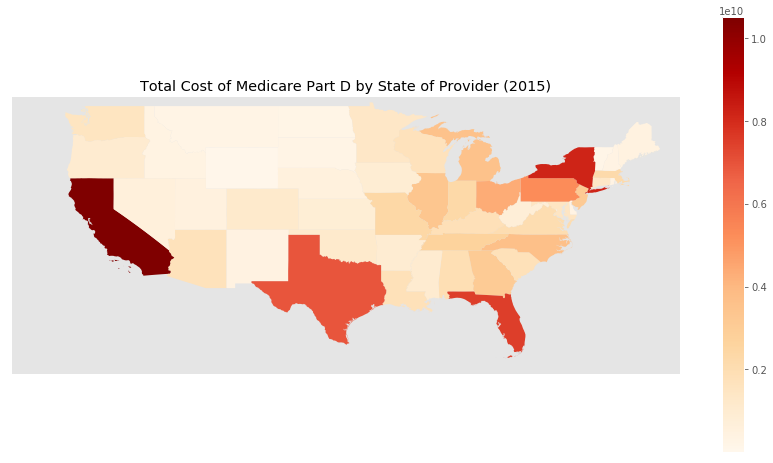

In [10]:
# Total Cost Map
states = gpd.read_file("cb_2016_us_state_500k/cb_2016_us_state_500k.shp")
cost_by_state_map = states.merge(cost_by_state, how = "inner", left_on = "STATEFP", right_on = "FIPS")
plot_US(cost_by_state_map, "total_cost15", "OrRd", True, 
        "Total Cost of Medicare Part D by State of Provider (2015)")

Above we see that the highest total cost states for the Medicare part D program in 2015 were California, Texas, New York, and Florida.  This seemed to match well with my initial expectation because these are large states commonly stereotyped for having a large elderly population. At this point I felt comfortable enough with the data to continue my analysis. 

In [11]:
# function to call API for number of elderly people in US
def get_65_and_older_state(fip_number):
    """gets the number of people whose age is >= 65 from 
    2010 US Census for the state with FIP # fip_number"""
    
    digits = [x for x in range(20,26)] + [x for x in range(44,50)]
    search_term = ",".join(["P01200" + str(x) for x in digits])   
    census_url = "https://api.census.gov/data/2010/sf1"
    param = {"get": search_term, "for": "state:{num:02d}".format(num = int(fip_number)), 
             "key": "64a4fe086a33dfcda0f6c65e2fb69854aff776d7"}
    results = requests.get(census_url, params=param)
    
    try:
        return sum([int(x) for x in results.json()[1][:-1]])
    except:
        return None

# get the number of elderly people for each state
valid_stateFIPS = abbv2FIPS.copy()
elderly_by_state = {i: get_65_and_older_state(valid_stateFIPS[i]) for i in valid_stateFIPS.keys()}
cost_by_state['nelderly'] = [dictionary_get_with_fail(elderly_by_state, s) for s in cost_by_state['state']]
cost_by_state['nelderly'] = pd.to_numeric(cost_by_state['nelderly'], errors = "coerce")

Next I was interested in observing the cost per Medicare part D member by state of prescriber. Initially, I thought that using census data to get the elderly population for each state would be a good way to obtain the number of elderly people (and therefore the Medicare part D population) for each state using the U.S. census API. Thus, I wrote the function above to extract the elderly population for any given state from the U.S. census API. However, using elderly counts from the Census API, I obtained some strange results, partially due to the fact that the most recent count on the number of elderly people is from 2010 and I was using it to normalize cost for all 3 years (makes no sense). 

Since the elderly population varies across the 3 years and since the Medicare part D program also includes disabled people, I decided to reconsider my strategy to normalize the cost data by state. Luckily, I found a [file](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/CMSProgramStatistics/Dashboard.html), also provided by the CMS, that contained the historical Medicare enrollment at the county level. Interesting statistics from this enrollment file are shown below.

In [12]:
# information on medicare population
prop = read_Enrollment_Data("Aged Disabled Yearly Cnts", 4, 
                                 ["Unnamed: 0", "Unnamed: 1", 2015, "2015.1", "2015.2"],
                                 ["med_cnt15", "med_cnt_eld15", "med_cnt_disb15"], cost_by_state)
prop_disb = prop['med_cnt_disb15'].sum() / prop['med_cnt15'].sum()
prop_partD = prop['partd_cnt15'].sum() / prop['med_cnt15'].sum()
print('Proportion of all 2015 Medicare Enrollees (not just Part D) that are disabled: {:.3%}'.format(prop_disb))
print('Proportion of all 2015 Medicare Enrollees that are also enrolled in Part D: {:.3%}'.format(prop_partD))

Proportion of all 2015 Medicare Enrollees (not just Part D) that are disabled: 16.031%
Proportion of all 2015 Medicare Enrollees that are also enrolled in Part D: 71.625%


In 2015, we see 16.031% of all Medicare Enrollees were disabled while only 71.625% of all Medicare enrollees were actually also enrolled in part D prescription coverage. Therefore, it was a good idea for me to decide not to use the data from the U.S. Census.

Now we can finally use this data to examine the average cost of the Medicare Part D program by state.

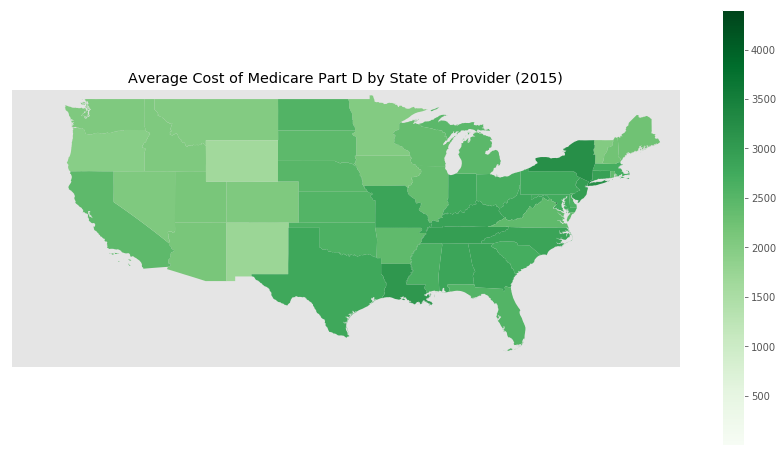

In [13]:
# average cost by state mape
plot_US(cost_by_state_map, "avg_cost15", "Greens", 
        True, "Average Cost of Medicare Part D by State of Provider (2015)")

From the plot above, we can spot 2 interesting patterns:

* First and foremost, there do appear to be slight variations in the average cost of Medicare part D by the state of the provider.  Unlike some choropleth maps, the boundaries in this case have some meaning because the total cost (and hence the average cost) of drugs in this dataset include all extra taxes and fees paid for any prescription.  As we can see below, much of the variation in the average cost of the Medicare Part D program by state is explained by the average number of claims in the state (correlation coefficient is between .645 and .725 for all three years).  Perhaps the extra state taxes and fees paid for the prescriptions could help reduce the variation in the average cost in the Medicare Part D program by state more (however, no comment can be made on the validity of this claim from the data I possess).

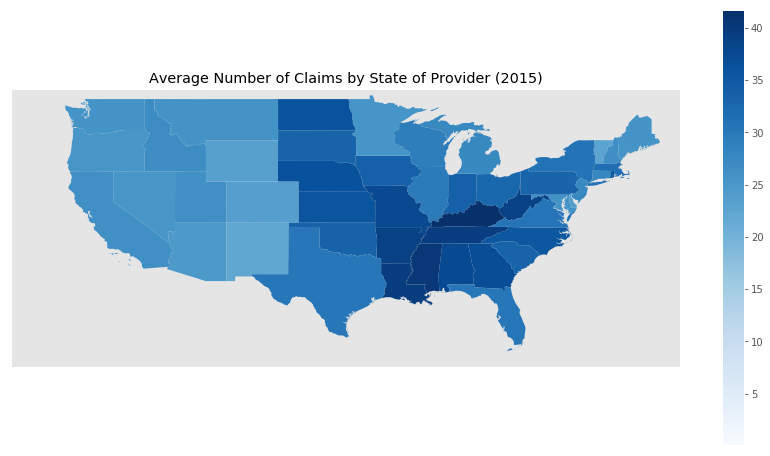

Correlation between Average Number of Claims and Average Cost by State (2013): 0.72432
Correlation between Average Number of Claims and Average Cost by State (2014): 0.67875
Correlation between Average Number of Claims and Average Cost by State (2015): 0.64433


In [14]:
# average number of claims by state of provider map
plot_US(cost_by_state_map, "avg_claims15", "Blues", 
        True, "Average Number of Claims by State of Provider (2015)")

# print correlation coefficients between average number of claims and average cost by state
for year in years:
    print("Correlation between Average Number of Claims and Average Cost by State (20{}):".format(year), 
          round(np.corrcoef(cost_by_state_map['avg_claims{}'.format(year)], 
                            cost_by_state_map['avg_cost{}'.format(year)])[0,1], 5))

* Secondly, we see that no state on the average cost map is as dark as the darkest label given on the legend (although New York and Louisiana are somewhat close). Although this seems like a mistake, it is not. As I discovered through exploratory analysis, Washington DC is included as a state/provence in the dataset and has the highest average cost per year.

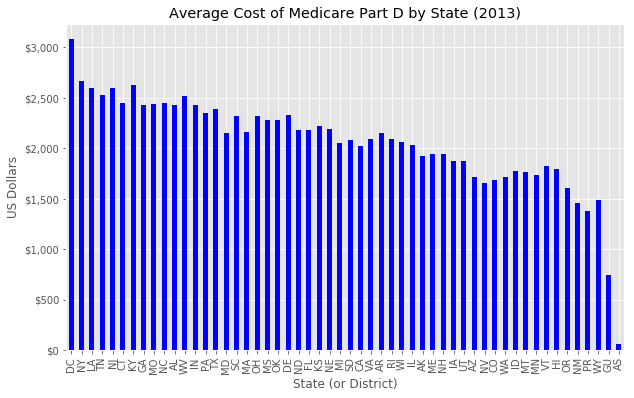

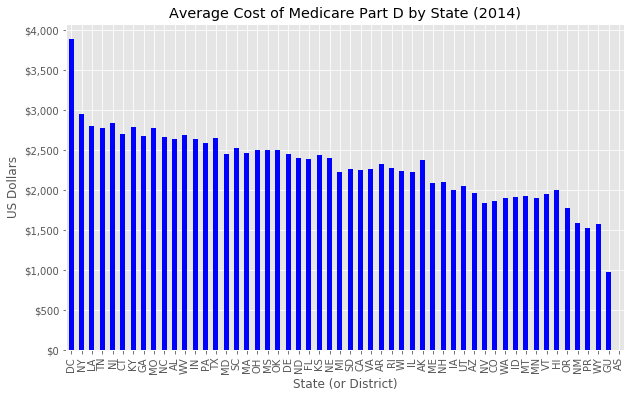

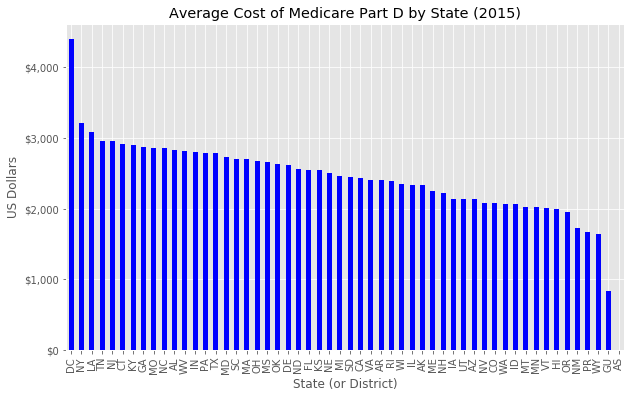

In [15]:
# bar plot of average cost for every year
for year in years:
    pandas_plot(cost_by_state.sort_values('avg_cost15'.format(year), ascending = False),
                "state", "avg_cost{}".format(year), "blue", 'bar', False,
                "State (or District)", "US Dollars", 
                "Average Cost of Medicare Part D by State (20{})".format(year))

In [16]:
# show information on Washington DC
DC = cost_by_state['state'] == 'DC'
cost_by_state[DC]

,state,total_cost13,num_claims13,total_cost14,num_claims14,total_cost15,num_claims15,FIPS,partd_cnt13,partd_cnt14,partd_cnt15,avg_cost13,avg_claims13,avg_cost14,avg_claims14,avg_cost15,avg_claims15,nelderly
49,DC,1.408502e+08,1364322,1.872167e+08,1430975,2.210265e+08,1458931,11,45743.0,48159.0,50291.0,3079.163508,29.825809,3887.471162,29.713553,4394.95218,29.009783,68809.0


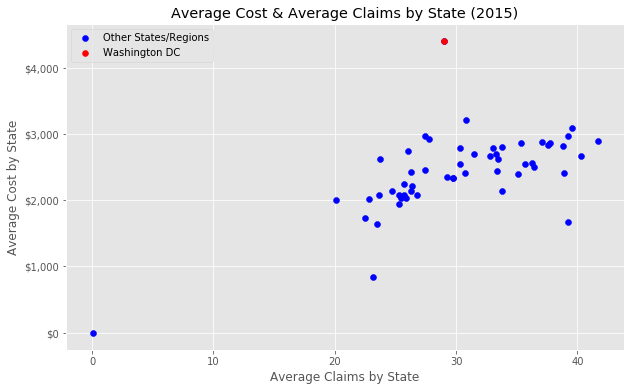

In [17]:
# scatter plot of state average cost on state average claims
fig, ax = plt.subplots()
state_iter = cost_by_state.iterrows()
_, row = next(state_iter)
ax.scatter(row['avg_claims15'],row['avg_cost15'], color = 'b', label="Other States/Regions")
for _, row in state_iter:
    ax.scatter(row['avg_claims15'], row['avg_cost15'], color = 'b', label = "_nolegend_")
ax.scatter(cost_by_state[DC]['avg_claims15'], cost_by_state[DC]['avg_cost15'], 
            color = "r", label = "Washington DC")
plt.legend(loc = "upper left") , plt.title("Average Cost & Average Claims by State (2015)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.xlabel("Average Claims by State"), plt.ylabel("Average Cost by State")
plt.show()

As we see above, Washington DC is in fact the state/region with the highest provider cost per eligible Medicare part D enrollee across all 3 years. I thought that one explanation for this is that Medicare part D members from nearby states (but not necessarily Washington DC) go into the city to get care, and under my methodology the cost of these patients are attributed to doctors in Washington DC and likely inflate my cost measure. However, if this were the case, then the number of claims per person would be much higher in Washington D.C. than in other region. As we see in the scatter plot above this is not the case.  Instead, we observe that Washington DC just seems to be quite an outlier.

In conclusion, we do see that costs do tend to vary quite a bit from state to state and costs tend to stay relatively stable over time, perhaps suggesting that the prescribing patterns of providers, state taxes, and/or other factors cause some variation in average cost from state to state. However, without being able to consider other factors, such as the rate at which people travel to other states to receive care, no definitive conclusion can be made about what makes average prescriber cost vary so much from state to state.

### Are there any patterns in outlying prescribers?  Does it appear that any of these prescribers are blatantly committing fraud?

In accordance of the theme of reducing the cost of the Medicare Part D program, it would be useful to look at outlying prescribers to determine if any [Medicare Fraud](https://en.wikipedia.org/wiki/Medicare_fraud) is present in the data. To answer this question, let's examine the total cost and the total number of prescriptions attributable to each provider.

In [18]:
query = """select name, npi, specialty, sum(num_claims) as num_claims, 
                  sum(cost) as total_cost, count(generic_name) as num_drugs
from rx2015
group by npi
"""
doc_spending = pd.read_sql_query(query, rx_conn)

doc_spending.to_csv("summaryData/SpendingByProvider.csv", index = False)

In [19]:
doc_spending = pd.read_csv("summaryData/SpendingByProvider.csv")
doc_spending.describe()[['num_claims', 'total_cost']]

,num_claims,total_cost
count,842386.000000,8.423860e+05
mean,1452.225568,1.216944e+05
std,3327.465127,3.397899e+05
min,11.000000,0.000000e+00
25%,50.000000,6.177125e+02
50%,213.000000,7.892035e+03
75%,1267.000000,1.014409e+05
max,294059.000000,2.018440e+07


As we see above, there were 842,386 doctors who prescribed to Medicare Part D in 2015. On average, each provider was responsible for 1,452 prescriptions being filled and for \$121,694 of cost on the Medicare part D program.  Although one can see that the distribution of the number of claims and the total cost per provider are both **heavily** skewed right, suggesting that there are some incredible outliers present.  I decided to make a simple scatterplot to investigate this and other patterns in the data.

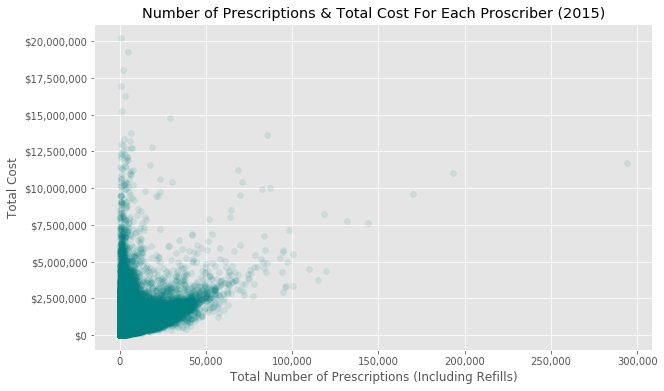

In [20]:
# scatter plot of the number of claims and total cost of each provider
fig, ax = plt.subplots(1, 1)
ax.scatter(doc_spending['num_claims'], doc_spending['total_cost'], alpha = .1, color = 'teal')
plt.ylabel("Total Cost")
plt.xlabel("Total Number of Prescriptions (Including Refills)")
plt.title('Number of Prescriptions & Total Cost For Each Proscriber (2015)')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

In the scatter plot above, each point represents a single provider for Medicare part D prescriptions in 2015.  The x-coordinate represents the number of prescriptions filled by Medicare patients of the provider (including refills) while the y-coordinate represents the total cost accrued by the Medicare patients of the provider in 2015.

This plot shows 2 extremely common patterns in the prescription patterns and accumulated plan cost. Doctors tend to either accumulate **very, very** high costs with a low number of prescriptions or tend to gradually accumulate costs via a filling a quite large number of prescriptions.

I hypothesize that the former of the two are specialists treating some diseases with expensive prescriptions while the latter are doctors overseeing many patients.

In [21]:
# use to make interactive plot interesting
def name_spec_topdrug(name):
    """ gets the specialty and top cost drug for the doctor with the name, 'name'.
    
    
    Note that typically this function would a very long time to return the query. However, because I 
    wrote the data to the SQL file with the phyisician name as the index, it works fast enough to be
    a usable method
    """
    
    name_query = """select name, specialty, generic_name
    from rx2015
    where name = '{}'
    order by cost desc
    limit 1
    """.format(name)
    spec_drug = pd.read_sql_query(name_query, rx_conn)
    return spec_drug.iloc[0,0] + "; " + spec_drug.iloc[0,1] + "; " + spec_drug.iloc[0,2]

In [22]:
# look at doctor's with abnormally high total cost
high_cost = doc_spending[(doc_spending['total_cost'] > 3000000)].copy()
labels = [name_spec_topdrug(x) for x in high_cost['name']]
high_cost['top_drug'] = [x.split("; ")[2] for x in labels]

In [23]:
# interactive plot for higher total cost prescribers
fig, ax = plt.subplots(figsize = (10,6))
scat = ax.scatter(high_cost['num_claims'], high_cost['total_cost'], color = 'teal')
plt.ylabel("Total Cost")
plt.xlabel("Total Number of Prescriptions (Including Refills)")
plt.title("2015 High Cost Providers (> $3,000,000 in Total Cost)")
pointlabs = plugins.PointLabelTooltip(scat,labels)
plugins.connect(fig, pointlabs)

# write interactive plot to file
with open('Figures/high_cost.html', 'w') as plot_file:
    plot_file.write(mpld3.fig_to_html(fig))

# show plot here
mpld3.display(fig)

To investigate whether large the high cost providers are specialists who cure expensive disease, I made an interactive version of the previous scatterplot for doctors with high accrued cost (greater than 3 million dollars).  This plot is displayed above; however, if for any reason it isn't viewable, you can also see it in `Figures/high_cost.html`.

When you hover over any individual point, you can see 3 pieces of information: (1) the name of the provider, (2) the specialty of the provider, (3) the drug responsible for the majority of the doctors prescribing costs.

From this we can see that the highest cost provider is Nicole Cheng, a physician assistant whose highest cost drug is `LEDIPASVIR/SOFOSBUVIR`.  This seems odd since a physician assistant is not considered to be type of specialized doctor. If one investigates more, they see that `LEDIPASVIR/SOFOSBUVIR` seems quite common amongst highest cost drugs for high cost doctors.

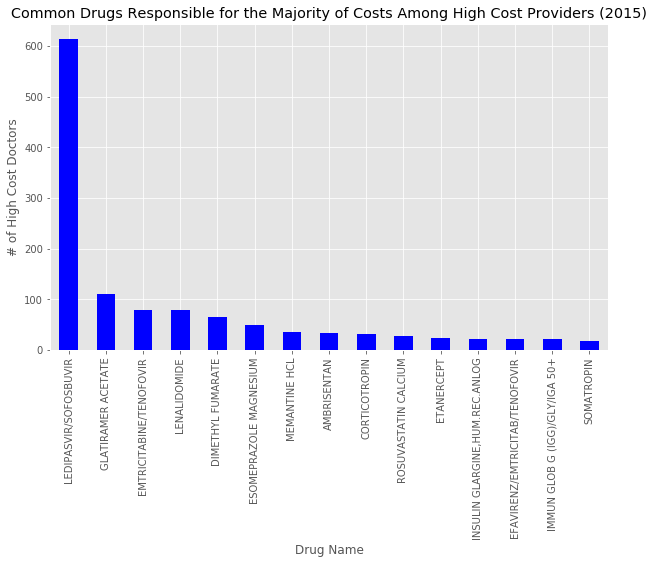

In [24]:
# show common drugs responsible for the majority of costs for high cost providers
top_drugs = high_cost.groupby("top_drug").agg({"name": "count"}).sort_values("name", ascending = False)

top_drugs.head(15).plot.bar(y = 'name', color = 'blue', legend = False)
plt.title("Common Drugs Responsible for the Majority of Costs Among High Cost Providers (2015)")
plt.xlabel("Drug Name")
plt.ylabel("# of High Cost Doctors")
plt.show()

From the bar plot, we can see that by far `LEDIPASVIR/SOFOSBUVIR`, used in treating Hepatitis C, is responsible for the majority of costs for most doctors prescribing more than \$3,000,000 in medication in 2015. A quick google search shows that the cost of `LEDIPASVIR/SOFOSBUVIR` is roughly [\$1,125 per pill wholesale](https://www.hepatitisc.uw.edu/page/treatment/drugs/ledipasvir-sofosbuvir) in the U.S. explaining how doctors can accumlate such high costs from the Medicare Part D program while prescribing a relatively small number of scripts. The high cost of this medication might be an explanation for why the Center for Disease Control has a campaign [for all baby boomers to be tested for Hepatitis C](https://www.cdc.gov/knowmorehepatitis/media/pdfs/factsheet-boomers.pdf).

The next most common drug is Glatiramer Acetate, a disease used to treat multiple sclerosis. 

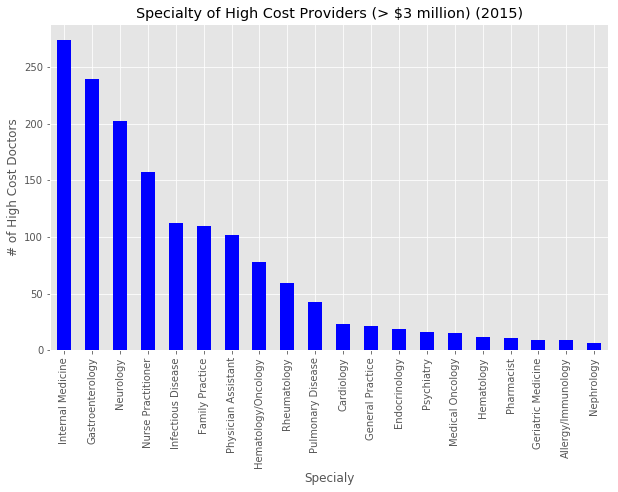

In [25]:
# specialty of high cost providers
spec = high_cost.groupby(["specialty"]).agg({"specialty":"count"}).sort_values("specialty", ascending=False)

spec.head(20).plot.bar(y = 'specialty', color = 'blue', legend = False)
plt.title("Specialty of High Cost Providers (> $3 million) (2015)")
plt.xlabel("Specialy")
plt.ylabel("# of High Cost Doctors")
plt.show()

Above we see that the most common high cost prescribers in 2015 appear to be providers in Internal Medicine or specialists involved in Gastroenterology or Neurology.  However, seemingly common, *unspecialized* providers such as Family Practice Doctors, Nurse Practitioners, and Physicians Assistants are also quite common across high cost providers.  The only explanation I could think of for why so many *unspecialized* providers are so common amongst high cost providers is that they are given the diagnosis from a specialist/collaborate with a specialist and are tasked with writing the prescriptions themselves.  However, there is no way to check/validate this from the data I found.

In [26]:
query = """select name, npi, city, state, specialty, sum(num_claims) as num_claims, 
                  sum(cost) as total_cost, count(generic_name) as num_drugs
from rx2015
where name = "Terence Frinks"
group by npi
"""
pd.read_sql_query(query, rx_conn)

,name,npi,city,state,specialty,num_claims,total_cost,num_drugs
0,Terence Frinks,1285761833,TUCKER,GA,Family Practice,294059,11720691.85,533


To determine whether or not high frequency providers are likely to commit fraud, I googled the name of the highest frequency provider, Terence Frinks (obtained from the `high_cost` plot), to find that he was [one of 122 doctors at Gwinnett Medical Center who specialize in Family Medicine](https://health.usnews.com/doctors/terence-frinks-593387).  The only explanation that I could come up with that would explain how his patients filled an astounishing **294,059 prescriptions** in 2015 (roughly 805.5 per day) is that when providers in the same hospital as Terence write a prescription it is somehow attributed to him. Even, if this is not the case it appears as if there is something strange, possibly fraud, is going on here (805.5 prescriptions filled per day is a massive amount).  Because the process of determine whether a particular doctor is possibly commiting fraud is quite labor intensive, I decided not to analyze any other cases.

In conclusion, the CMS should examine cases where expensive prescriptions (such as the Hepatitis C drug `LLEDIPASVIR/SOFOSBUVIR`) or where a massive number of prescriptions are being written by a single provider for possible Medicare fraud.

### Is there a significant cost difference in generic drugs versus brand name drugs? If so, why does this seem to be the case?

According to the FDA, a **generic drug** is a medication created to be the same as an existing approved brand-name drug in dosage form, safety, strength, route of administration, quality, and performance characteristics.  So, generics should provide the same level of treatment as the brand name drug, except, because they are produced by firms that do not have to invest money into the research and development of the drug, they should intuitively be cheaper.

Let's see what differences we can find between how generic drugs and brand-name drugs are prescribed.

In [27]:
query = """select generic_name, drug_name, sum(num_claims) as num_claims, sum(cost) as total_cost
from rx2015
group by generic_name, drug_name
"""
drugs = pd.read_sql_query(query, rx_conn)
drugs.to_csv("summaryData/Drugs2015.csv", index = False)

In [28]:
# read in drug information from 2015
drugs = pd.read_csv("summaryData/Drugs2015.csv")
drugs = drugs[~drugs.generic_name.str.contains("[0-9%]")]    # filter out drugs #'s in name and/or % signs
drugs['avg_cost'] = drugs['total_cost'] / drugs['num_claims']
isgeneric = drugs['drug_name'].str.replace("-","/").isin(drugs['generic_name'])

# get information on generic and brand name drugs
generics, brand_name = drugs[isgeneric], drugs[~isgeneric]
{"# of Brand Names":brand_name.count()['drug_name'], "# of Generics": generics.count()['drug_name']}

{'# of Brand Names': 1924, '# of Generics': 683}

Above we see that there are 683 generic drugs and 1,924 name brand drugs prescribed by Medicare part D providers in 2015.

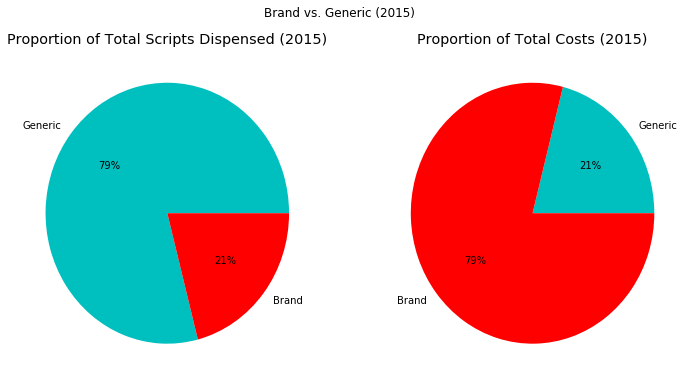

In [29]:
def simple_pie(vals, llables, ccols, ttitle):
    """function for making a simple pie chart
    
    Arguments:
        -vals (array-like): values to make pie chart from
        -llabels (list of strings): labels to use for pie charts
        -ccols (list of strings): colors to use for pie chart
        -ttitle (string): title for the chart
    """
    plt.pie(vals, labels = llables, autopct = "%.0f%%",colors = ccols)
    plt.title(ttitle)

# make pie charts about generic and brand name drugs
fig,ax = plt.subplots(figsize = (12,6))
plt.subplot(1, 2, 1)
simple_pie([generics['num_claims'].sum(), brand_name['num_claims'].sum()], ["Generic", "Brand"], 
           ['c', 'red'], "Proportion of Total Scripts Dispensed (2015)")
plt.subplot(1, 2, 2)
simple_pie([generics['total_cost'].sum(), brand_name['total_cost'].sum()], ["Generic", "Brand"], 
           ['c', 'red'], "Proportion of Total Costs (2015)")
plt.suptitle("Brand vs. Generic (2015)")
plt.show()

As we see above, generic drugs account for 79% of all prescriptions made and filled and yet only account for 21% of the total cost. This suggests that generic drugs are much less expensive than brand name drugs on average. However, this analysis is slightly misleading because it does not consider the conditions or contexts in which the brand drugs are being prescribed.  For example, it could be the case that brand name drugs are only being used to treat very serious conditions (such as Hepatitis C or certain cancers).

In order to compare apples to apples, I further focus my analysis to only the brand name drugs that have a generic equivalent and their respective generic equivalents.

In [30]:
# get brand name drugs with generic alternatives and the corresponding generic drugs
brand_inst_gen = brand_name[brand_name['generic_name'].isin(generics['generic_name'])]
print("Number of brand name drugs that had a generic alternative:", brand_inst_gen.shape[0])
gen_alt = generics[generics['generic_name'].isin(brand_inst_gen['generic_name'])]

Number of brand name drugs that had a generic alternative: 842


In [31]:
def to_merge_form(df, col_list):
    """make calculater average cost from the the total cost and num_claims columns and replace the
    column names from the list col_list
    
    Arguments:
        -df (pandas df): dataframe to format
        -col_list (list): names for the columns of the dataframe to return
        
    Returns:
        -df (pandas df): properly formatted dataframe
    """
    df = df.groupby("generic_name").sum()
    df['avg_cost'] = df['total_cost'] / df['num_claims']
    df.columns = col_list
    return df

# create a data frame whose index is the generic drug name whose columns are generics and whose columns are
# info on the brand name and average cost drugs
brand_inst_gen = to_merge_form(brand_inst_gen, ["brand_claims", "brand_total_cost", "brand_avg_cost"])
gen_alt = to_merge_form(gen_alt, ["gen_claims", "gen_total_cost", "gen_avg_cost"])
side_by_side = brand_inst_gen.merge(gen_alt, left_index=True, right_index=True)
side_by_side.head()

,brand_claims,brand_total_cost,brand_avg_cost,gen_claims,gen_total_cost,gen_avg_cost
generic_name,,,,,,
ABACAVIR/LAMIVUDINE/ZIDOVUDINE,1015,1590302.69,1566.800680,7678,10171675.91,1324.781963
ACAMPROSATE CALCIUM,12,1253.89,104.490833,9032,1314229.30,145.508116
ACARBOSE,34,3923.36,115.392941,128797,6847162.87,53.162441
ACEBUTOLOL HCL,133,29528.90,222.021805,59909,1057749.65,17.655939
ACETAZOLAMIDE,263,118858.77,451.934487,164248,19889470.00,121.094138


In [32]:
# bools to use to calculate population statistics
more_generic = side_by_side['brand_claims'] < side_by_side['gen_claims']
generic_cheaper = side_by_side['brand_avg_cost'] > side_by_side['gen_avg_cost']

# print interesting population statistics
def generic_string(more, cheaper, number):
    x = "NON-" if more == False else ""
    y = "NOT " if (cheaper == False) != (more == False) else ""
    return ("\t-{}generics are prescribed most often when they are {}the least expensive: \t {:.2f}%"
            .format(x,y, 100 * number))

print("Number of generic drugs that are also prescribed under brand name:", len(side_by_side))
print(generic_string(True, True, sum(more_generic & generic_cheaper)/len(side_by_side)))
print(generic_string(True, False, sum(more_generic & ~generic_cheaper)/len(side_by_side)))
print(generic_string(False, True, sum(~more_generic & generic_cheaper)/len(side_by_side)))
print(generic_string(False, False, sum(~more_generic & ~generic_cheaper)/len(side_by_side)))

# print the generic and brand name average cost for the brand name drugs with a generic alternative
print("\nFor brand name drugs with generic alternatives and their respective generics:")
print("\t-Generic Average Cost: ${:.2f}".
      format(side_by_side['gen_total_cost'].sum() / side_by_side['gen_claims'].sum()))
print("\t-Brand Name Average Cost: ${:.2f}".
      format(side_by_side['brand_total_cost'].sum() / side_by_side['brand_claims'].sum()))

Number of generic drugs that are also prescribed under brand name: 435
	-generics are prescribed most often when they are the least expensive: 	 80.92%
	-generics are prescribed most often when they are NOT the least expensive: 	 5.98%
	-NON-generics are prescribed most often when they are NOT the least expensive: 	 10.80%
	-NON-generics are prescribed most often when they are the least expensive: 	 2.30%

For brand name drugs with generic alternatives and their respective generics:
	-Generic Average Cost: $21.68
	-Brand Name Average Cost: $158.70


Note that there are 435 generic drugs for which doctors also prescribe a brand name equivalent. Around 92% of the time, generic drugs are on average less expensive than their branded counter parts.  A question that this raised for me is why would a branded drug be more expensive than it's generic counter part.  According to [this article](https://www.wsj.com/articles/SB1013554745899279480) from the Wall Street Journal, one explanation for this phenomenon is federal legislation forcing pharmaceutical companies to offer rebates to states in exchange for receiving payment from Medicare.  Therefore, one possible way to save money could be to analyze whether or not the rebates given from a drug company will offset the higher cost of the drugs to make it profitable than prescribing generics.

We also see that the brand name average cost for brand name drugs with generic alternatives also tend to be quite a bit more expensive than their generic alternatives on average.

One question that I had after preforming the above analysis was whether or not the branded drugs above were representative of the high total cost differnce that was apparent between brand name drugs and generic drugs in the pie chart.

In [33]:
def print_drug_prop(drug_df, col_list = ['num_claims', 'total_cost']):
    """prints useful stats for drugs from drug_df
    """
    #calculate stats
    s1 = drug_df[col_list[0]].sum() / drugs['num_claims'].sum() * 100
    s2 = drug_df[col_list[1]].sum() / drugs['total_cost'].sum() * 100
    
    #print results
    print("\t-Proportion of Total Claims (2015): \t{:.2f}%".format(s1))
    print("\t-Proportion of Total Cost (2015): \t{:.2f}%".format(s2))


print("Brand Name Drugs with Generic Equivalents:")
print_drug_prop(side_by_side, ['brand_claims', 'brand_total_cost'])

brand_no_gen = brand_name[~brand_name['generic_name'].isin(generics['generic_name'])]
print("\nBrand Name Drugs with No Generic Equivalents:") 
print_drug_prop(brand_no_gen)

Brand Name Drugs with Generic Equivalents:
	-Proportion of Total Claims (2015): 	7.85%
	-Proportion of Total Cost (2015): 	15.10%

Brand Name Drugs with No Generic Equivalents:
	-Proportion of Total Claims (2015): 	13.11%
	-Proportion of Total Cost (2015): 	63.91%


Above we see that the brand name drugs with generic equivalents account for 7.85% of all total claims and 15.10% of all costs in 2015. Also, brand name drugs that have no generic equivalent account for roughly 63.91% of the total cost, while being only 13.11% of the total prescriptions written.  Thus, it appears that brand name drugs with no generic equivalents are by far the most expensive segment of prescriptions in the Medicare part D program.  It seems likely that most expansive brand name drugs that have no generic equivalent are likely still under patent.  When drug companies still have a drug under patent, they often charge a pretty penny for their drugs because (1) drug companies want to recuperate the investment of research and development and (2) for extra money.  This interpretation suggests that Medicare is being price gouged on drugs that are still under patent.

In conclusion, it appears that brand name drugs are responsible for the majority of costs for the Medicare part D program, despite being a minority of the total drugs prescribed.  When one controls for the type of generic, brand name drugs tend to be more expensive than their generic counterparts (a minority aren't - likely because mandatory rebates lower the effective price of the brand drug).  Finally, branded drugs with no generic alternative seem to be the most expensive segment in the Medicare part D program.

### Does the average cost of drugs increase by 8-12% per year (as assumed in the private insurance market)?  If so, what seems to be driving this increase?

In [34]:
def print_stat_increase(num, denom, prompt, fmt):
    """prints information about increases in the average produced by (num/denom)
    
    Arguments:
        -num (string): name of column to use in numerator of statistic
        -denom (string): name of column to use in denomentor of statistic
        -prompt (string): prompt to print in front of statistic
        -fmt (string): format to print statistic in
    
    Returns:
        -None: No return value
    """
    stats = []
    for year in years:
        stat = (cost_by_state[num + '{}'.format(year)].sum()
                / cost_by_state[denom + '{}'.format(year)].sum())
        print(prompt, ('in 20{}: '+ fmt).format(year, stat))
        stats.append(stat)
    
    print()
    for i in range(2):
        print("% increase from 20{} to 20{}: {:.2f}%".format(years[i], years[i+1], 
                                                             (stats[i+1]/stats[i] - 1)*100))
    return None

# print change in cost per medicare part D member
print("Cost per Part D Member:")
print_stat_increase("total_cost", "partd_cnt", "Average prescription cost per Medicare part D member", "${:,.2f}")

Cost per Part D Member:
Average prescription cost per Medicare part D member in 2013: $2,206.46
Average prescription cost per Medicare part D member in 2014: $2,427.89
Average prescription cost per Medicare part D member in 2015: $2,595.97

% increase from 2013 to 2014: 10.04%
% increase from 2014 to 2015: 6.92%


Above we see that average prescription cost per Medicare part D member increased by 10.04% from 2013 to 2014 and by 6.92% from 2014 to 2015, suggesting that prescription costs have seemed to rise by around 8-12% per year.

I believe that this is caused by either  increased prescription count per Medicare part D member, rising drug cost (i.e. cost of drug per prescription), or some combination of the two.

In [35]:
# print change in the number of prescriptions per part D member
print('\nNumber of Prescriptions per Part D Member:')
print_stat_increase("num_claims", "partd_cnt", "# of prescriptions per Medicare part D member", "{:,.2f}")

# print change in the cost per prescription
print('\nCost per Prescription:')
print_stat_increase("total_cost", "num_claims", "Prescription cost per script", "${:,.2f}")


Number of Prescriptions per Part D Member:
# of prescriptions per Medicare part D member in 2013: 32.40
# of prescriptions per Medicare part D member in 2014: 31.70
# of prescriptions per Medicare part D member in 2015: 30.98

% increase from 2013 to 2014: -2.16%
% increase from 2014 to 2015: -2.28%

Cost per Prescription:
Prescription cost per script in 2013: $68.11
Prescription cost per script in 2014: $76.59
Prescription cost per script in 2015: $83.80

% increase from 2013 to 2014: 12.46%
% increase from 2014 to 2015: 9.41%


As we see above, the number of prescriptions per part D member has actually decreased across the 3 year period while the cost per prescription has actually increased significantly across the 3 year period.  One may wonder why the prescription cost per prescription has raised so highly over the past 3 years.  I investigate this below.

In [36]:
# saves drug information for 2014 and 2015
for year in reversed(years[1:]):
    query = """select generic_name, sum(cost) as total_cost{}, sum(num_claims) as numrx{}
    from rx20{} 
    group by generic_name
    order by total_cost{} desc""".format(year, year, year, year)
    tmp = pd.read_sql_query(query, rx_conn)
    tmp['avg_cost{}'.format(year)] = tmp['total_cost{}'.format(year)] / tmp['numrx{}'.format(year)]
    try:
        rx = rx.merge(tmp[~tmp.generic_name.str.contains("[0-9%]")], how = 'left', on = "generic_name")
    except NameError:
        rx = tmp[~tmp.generic_name.str.contains("[0-9%]")].copy()

# cache to csv file
rx.to_csv("summaryData/CostClaimsByDrug.csv", index=False)

In [37]:
# read in drug information for 2014 and 2015
rx = pd.read_csv("summaryData/costClaimsByDrug.csv")
rx = rx.set_index("generic_name")

# make interactive plot of drug
avg_drug_cost = [cname for cname in rx.columns.values if 'avg_cost' in cname]
avg_drug_cost.reverse()
rxyears = np.arange(2014,2016)

fig, ax = plt.subplots(figsize = (8,6))

for name, row in rx[avg_drug_cost].iterrows():
    ccol = 'red' if (pd.to_numeric(row)[0] < pd.to_numeric(row)[1]) else 'blue' 
    drug = ax.plot(rxyears, pd.to_numeric(row), ccol, alpha=.1)[0]
    linelabs = plugins.LineLabelTooltip(drug,name)
    plugins.connect(fig, linelabs)
    
ax.set_title("Average Cost of Drugs (per script) by Year")
ax.set_ylabel("Average Cost")
plt.xticks(rxyears)

# write interactive plot to html file
with open('Figures/increasing_cost.html', 'w') as plot_file:
    plot_file.write(mpld3.fig_to_html(fig))

# show interactive plot here
mpld3.display(fig)

Above is the average cost per script of drugs that were prescribed both in 2014 and 2015. Each line is representative of a single drug and is colored red if the average cost increased from 2014 to 2015 and blue if the average cost decreased in from 2014 to 2015.  Whenever you hover over a line, you can see what drug it corresponds to.  As we see above, many drugs appear to have increased in average cost from 2014 to 2015, especially those with higher average cost. As we can see, it appears that many of the most expensive drugs have increased in price for no clear reason. 

Also, because it is quite difficult to determine what most of the data is doing in the aggregate from this interactive figure, it may be useful to supplement this figure with some statistics.

In [38]:
# propotion of drugs that increased in price
incr_rx = rx.dropna(subset=["avg_cost14", "avg_cost15"])
incr = (incr_rx["avg_cost15"] > incr_rx["avg_cost14"])
prop_incr = incr.sum() / incr_rx.shape[0]

print("Proportion of drugs that increased in average cost from 2014 to 2015: {:.2f}%\n".format(prop_incr * 100))

# print information about the change in average cost for drugs that have increased in average cost
# (and have decreased in average cost) from 2014 to 2015
def print_script_change():
    for word in ['increase', 'decrease']:
        filt = incr if word == 'increase' else ~incr
        s1 = (incr_rx[filt]['total_cost15'].sum() / incr_rx[filt]['numrx15'].sum() - 
            incr_rx[filt]['total_cost14'].sum() / incr_rx[filt]['numrx14'].sum())
        s2 = incr_rx[filt]['numrx15'].sum() / incr_rx['numrx15'].sum()
        print("Average delta in cost for drugs that {}d in average cost from 2014 to 2015: \t$  {:.2f}".
              format(word, s1))
        print("Proportion of 2015 scripts for drugs that {}d in average Cost from 2014 to 2015: \t{:.2f} %".
              format(word, s2 *100))

print_script_change()

Proportion of drugs that increased in average cost from 2014 to 2015: 60.42%

Average delta in cost for drugs that increased in average cost from 2014 to 2015: 	$  25.50
Proportion of 2015 scripts for drugs that increased in average Cost from 2014 to 2015: 	35.47 %
Average delta in cost for drugs that decreased in average cost from 2014 to 2015: 	$  -2.70
Proportion of 2015 scripts for drugs that decreased in average Cost from 2014 to 2015: 	64.53 %


Above we see that the majority of drugs (60.42%) increased in average cost from 2014 to 2015.  These drugs consisted of 35.47% of the total prescriptions consumed by Medicare part D members in 2015 and increased in cost, on average, by \$25.50 from 2014.

Likewise 39.58% of all drugs prescribed decreased in average cost from 2014 to 2015, on average this decrease was \$2.70. In terms of the total number of drugs consumed by Medicare part D members in 2015, this segment accounted for 64.53% of the total drugs prescribed.

In conclusion, it does appears that drug costs per person do seem to be increasing by 8-12% per year.  An elementary analysis suggests that this is due to the increasing cost of price per prescription, as the number of prescriptions per person has had a slight downward trend.  The majority of drugs (60.42%) increased in cost per prescription from 2014 to 2015. Given the data in this analysis, nothing of value can be said to answer why these costs are increasing so rapidly. Therefore, I will have to wait for another day to find my answer.